In [1]:
import pandas as pd

naslib_path = '../../zero_cost/NASLib'
benchmark = 'zc_nasbench101'

In [2]:
from zc_combine.utils.naslib_utils import load_search_space, parse_scores

search_space = load_search_space(naslib_path, benchmark)
dfs = parse_scores(search_space)

In [3]:
dataset = 'cifar10'
data = dfs[dataset]

In [4]:
from zc_combine.features.conversions import nb101_to_graph

nets = {i: nb101_to_graph(data.loc[i]) for i in data.index}

In [5]:
import json

with open('../zc_combine/configs/nb101_first.json', 'r') as f:
    cfg = json.load(f)

In [6]:
from zc_combine.features.nasbench101 import feature_func_dict
from zc_combine.features.dataset import get_feature_dataset

feature_dataset = get_feature_dataset(nets, cfg, feature_func_dict)
feature_dataset.keys()

dict_keys(['op_count', 'min_path_len', 'max_op_on_path', 'node_degree', 'num_paths'])

In [7]:
features = ['op_count', 'min_path_len', 'max_op_on_path', 'node_degree', 'num_paths']
dataset = pd.concat([feature_dataset[f] for f in features], axis=1)
dataset['val_accs'] = data['val_accs']
dataset

,op_count_0,op_count_1,op_count_2,op_count_3,op_count_4,min_path_len_banned_[],min_path_len_banned_[2],min_path_len_banned_[3],min_path_len_banned_[4],"min_path_len_banned_[2, 3]",...,"node_degree_allowed_[2, 4]_max_out","node_degree_allowed_[2, 4]_max_in","node_degree_allowed_[2, 3]_in_degree","node_degree_allowed_[2, 3]_out_degree","node_degree_allowed_[2, 3]_avg_in","node_degree_allowed_[2, 3]_avg_out","node_degree_allowed_[2, 3]_max_out","node_degree_allowed_[2, 3]_max_in",num_paths_,val_accs
idx,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,1,3,2,2,3,2,7,...,2,2,2,1,0.428571,0.571429,1,2,4,92.417866
1,1,1,0,3,2,4,4,7,7,7,...,1,2,0,1,0.428571,0.428571,1,1,3,89.423078
2,1,1,2,2,1,2,2,7,2,7,...,1,2,2,1,0.714286,0.857143,2,2,4,92.808491
3,1,1,2,2,1,3,3,7,4,7,...,1,2,1,2,0.571429,0.714286,2,1,3,91.055691
4,1,1,2,2,1,3,3,7,4,7,...,2,1,1,1,1.000000,0.714286,2,2,4,89.913863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9776,1,1,2,0,3,1,1,1,1,1,...,1,3,0,0,0.285714,0.285714,1,1,4,93.750000
9777,1,1,0,1,4,3,3,7,7,7,...,1,1,0,1,0.142857,0.285714,1,1,2,90.665066
9778,1,1,2,2,1,3,7,3,3,7,...,1,2,1,2,0.857143,0.857143,2,2,6,89.763623


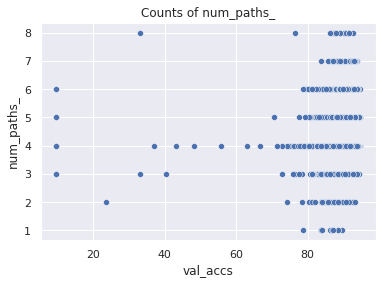

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plot_df = feature_dataset['num_paths'].copy()
plot_df['val_accs'] = data['val_accs']

import os
#os.mkdir('tmp')

for i, c in enumerate(plot_df.columns):
    if i > 5 or c == 'val_accs':
        continue
    plt.figure()
    sns.scatterplot(data=plot_df, x='val_accs', y=c)
    plt.title(f"Counts of {c}")
    #plt.savefig(f'tmp/{c}.png')
    plt.show()

In [9]:
proxy_cols = [c for c in data.columns if c not in ['random', 'rank', 'new_net', 'net']]


def get_dataset(feature_dfs, proxy_df, features, cols):
    feat_dfs = [feature_dfs[f] for f in features]
    prox_df = proxy_df[cols]

    res_data = pd.concat([*feat_dfs, prox_df], axis=1)

    y = proxy_df['val_accs'].loc[res_data.index]
    if 'val_accs' in res_data:
        res_data.drop(columns=['val_accs'], inplace=True)

    return res_data, y

features = ['op_count', 'min_path_len', 'max_op_on_path', 'node_degree']
full_data, full_y = get_dataset(feature_dataset, data, features, ['flops', 'params'])
print(full_data.shape)
full_data

(9781, 70)


,op_count_0,op_count_1,op_count_2,op_count_3,op_count_4,min_path_len_banned_[],min_path_len_banned_[2],min_path_len_banned_[3],min_path_len_banned_[4],"min_path_len_banned_[2, 3]",...,"node_degree_allowed_[2, 4]_max_out","node_degree_allowed_[2, 4]_max_in","node_degree_allowed_[2, 3]_in_degree","node_degree_allowed_[2, 3]_out_degree","node_degree_allowed_[2, 3]_avg_in","node_degree_allowed_[2, 3]_avg_out","node_degree_allowed_[2, 3]_max_out","node_degree_allowed_[2, 3]_max_in",flops,params
0,1,1,1,1,3,2,2,3,2,7,...,2,2,2,1,0.428571,0.571429,1,2,1272.747008,8.555530
1,1,1,0,3,2,4,4,7,7,7,...,1,2,0,1,0.428571,0.428571,1,1,870.159360,5.878154
2,1,1,2,2,1,2,2,7,2,7,...,1,2,2,1,0.714286,0.857143,2,2,564.941824,3.729162
3,1,1,2,2,1,3,3,7,4,7,...,1,2,1,2,0.571429,0.714286,2,1,564.941824,3.729162
4,1,1,2,2,1,3,3,7,4,7,...,2,1,1,1,1.000000,0.714286,2,2,496.800768,3.292298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9776,1,1,2,0,3,1,1,1,1,1,...,1,3,0,0,0.285714,0.285714,1,1,645.303552,4.276808
9777,1,1,0,1,4,3,3,7,7,7,...,1,1,0,1,0.142857,0.285714,1,1,5873.832960,39.974282
9778,1,1,2,2,1,3,7,3,3,7,...,1,2,1,2,0.857143,0.857143,2,2,564.941824,3.729162
9779,1,1,2,2,1,2,2,3,2,7,...,1,1,3,1,0.857143,0.714286,1,3,286.625984,1.861666


In [10]:
import numpy as np
from scipy.stats import kendalltau, spearmanr
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


def get_splits(fd, fy, train_size=100, seed=42):
    return train_test_split(fd, fy, random_state=seed, train_size=train_size)

def eval_rf(trx, tex, tryy, tey, n_times=1, random_state=43):
    res = {'score': [], 'tau': [], 'corr': []}
    rfs = []
    for i in range(n_times):
        rf = RandomForestRegressor(random_state=random_state + i, n_estimators=100)
        rf.fit(trx, tryy)
        res['score'].append(rf.score(tex, tey))

        preds = rf.predict(tex)
        res['tau'].append(kendalltau(preds, tey)[0])
        res['corr'].append(spearmanr(preds, tey)[0])
        rfs.append(rf)

    return rfs, res

def print_means(res):
    print(", ".join([f"{k}: {np.mean(v)}" for k, v in res.items()]))

In [11]:
import numpy as np

skip_dis = True

features = ['op_count', 'min_path_len', 'max_op_on_path', 'node_degree']
seed = 44
for ts in [100, 200, 1000]:
    if skip_dis:
        break

    print(f"Train size {ts}")
    for prox in proxy_cols:
        for include_fp in [True, False]:
            if prox in ['flops', 'params']:
                continue
            print(prox, "" if include_fp else " no fp")

            plist = ['flops', 'params', prox] if include_fp else [prox]
            fd, fy = get_dataset(feature_dataset, data, features, plist)
            data_splits = get_splits(fd, fy, train_size=ts, seed=seed)

            _, res = eval_rf(*data_splits, n_times=5)
            print_means(res)
            print()

In [12]:
ts = 1000
seed = 45

add_low_net = False
low_idx = 1571

all_proxies = False
prox_to_include = []
prox_to_include = ['fisher']
with_features = True

features = ['op_count', 'min_path_len', 'max_op_on_path', 'node_degree']
feat_list = features if with_features else []

# proxies to add to data
def_proxlist = ['params', 'flops'] if prox_to_include is None else ['params', 'flops', *prox_to_include]
prox_list = proxy_cols if all_proxies else def_proxlist

fd, fy = get_dataset(feature_dataset, data, feat_list, prox_list)
train_X, test_X, train_y, test_y = get_splits(fd, fy, train_size=ts, seed=seed)

if add_low_net:
    train_X.loc[low_idx] = test_X.loc[low_idx]
    train_y.loc[low_idx] = test_y.loc[low_idx]
    test_X.drop(low_idx, inplace=True)
    test_y.drop(low_idx, inplace=True)

rfs, res = eval_rf(train_X, test_X, train_y, test_y, n_times=5)
print_means(res)
rf_fitted = rfs[0]
preds = rf_fitted.predict(fd)
preds

score: 0.1419865665463301, tau: 0.7471654793691525, corr: 0.9115287316905174


array([92.09655458, 89.68459433, 91.75200373, ..., 90.11888993,
       91.29777688, 92.93629807])

In [13]:
trainpreds = rf_fitted.predict(train_X)

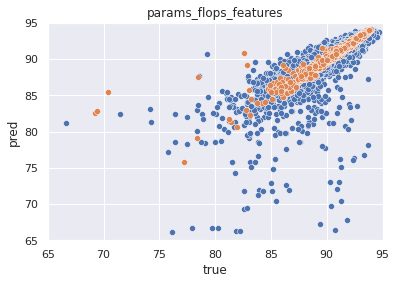

In [14]:
sns.scatterplot(data=pd.DataFrame({'pred': preds, 'true': fy}), x='true', y='pred')
sns.scatterplot(data=pd.DataFrame({'pred': trainpreds, 'true': train_y}), x='pred', y='true')
#plt.ylim(70, 95)

plt.xlim(65, 95)
plt.ylim(65, 95)

plt_name = f"{'all_proxies' if all_proxies else 'params_flops'}_{'features' if with_features else 'no_features'}"
plt.title(plt_name)
#plt.savefig(f"tmp/{plt_name}.png")
plt.show()

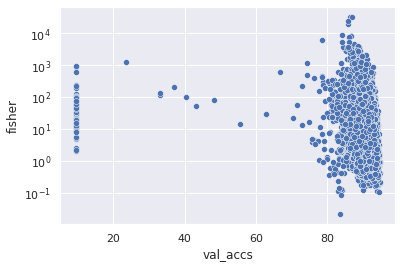

In [246]:
sns.scatterplot(data=data, x='val_accs', y='fisher')
plt.yscale('log')
plt.show()

In [247]:
import torch
import torch.nn as nn
from torch_geometric.nn.conv import GINConv
from torch_geometric.nn import global_add_pool
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import dense_to_sparse


def to_dataset(nets, y_accuracies, batch_size=32, shuffle=True):
    y_accuracies = (y_accuracies - y_accuracies.mean()) / y_accuracies.std()
    ind_graphs = []

    for oo, ops, graph in nets:
        ops = [[(1 if i == o else 0) for o in enumerate(oo)] for i in ops]
        x_features, adjacency = torch.Tensor(ops), torch.Tensor(nx.adjacency_matrix(graph).todense())
        ind = x_features, dense_to_sparse(adjacency)[0] 
        ind_graphs.append(ind)
        
    data = [Data(x=ind[0], edge_index=ind[1], y=y) for ind, y in zip(ind_graphs, y_accuracies)]
    return DataLoader(data, batch_size=batch_size, shuffle=shuffle)


def get_layer_sizes(n_layers, hidden_size, first_size=None, last_size=None):
    for i in range(n_layers):
        if i == 0 and first_size is not None:
            yield first_size, hidden_size
        elif i == (n_layers - 1) and last_size is not None:
            yield hidden_size, last_size
        else:
            yield hidden_size, hidden_size


def apply_layer_dropout_relu(x, layers, p, training):
    for i, lin in enumerate(layers):
        if i != 0:
            x = F.relu(x)
            x = F.dropout(x, p=p, training=training)
        x = lin(x)
    return x


class MLP(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, n_linear=2):
        super().__init__()

        sizes = get_layer_sizes(n_linear, hidden_dim, first_size=input_dim)
        self.linears = nn.ModuleList([nn.Linear(indim, outdim) for indim, outdim in sizes])
        self.batch_norms = nn.ModuleList([nn.BatchNorm1d(hidden_dim) for _ in range(n_linear - 1)])

    def forward(self, x):
        for i, lin in enumerate(self.linears):
            if i != 0:
                x = self.batch_norms[i - 1](x)
                x = F.relu(x)
            x = lin(x)
        return x


def _get_MLP(n_in, n_hidden, n_linear, i):
    return MLP(n_in if i == 0 else n_hidden, n_hidden, n_linear=n_linear)


class GINConcat(torch.nn.Module):
    def __init__(self, n_node_features=5, n_hidden=32, n_convs=3, n_linear=2, n_mlp_linear=2, dropout=0.1,
                 n_hidden_linear=32):
        super().__init__()

        # convs are followed by batch norm and ReLU
        self.convs = nn.ModuleList(
            [GINConv(_get_MLP(n_node_features, n_hidden, n_mlp_linear, i)) for i in range(n_convs)]
        )
        self.batch_norms = nn.ModuleList([nn.BatchNorm1d(n_hidden) for _ in range(n_convs)])

        # compute input size of linear layers
        lin_dim = (n_hidden * n_convs + n_node_features)

        lin_sizes = get_layer_sizes(n_linear, n_hidden_linear, first_size=lin_dim, last_size=1)
        self.lins = torch.nn.ModuleList([nn.Linear(indim, outdim) for indim, outdim in lin_sizes])

        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        # concat readout - inputs
        h_out = []
        h_out.append(global_add_pool(x, batch))

        for conv, bn in zip(self.convs, self.batch_norms):
            x = conv(x, edge_index)
            x = bn(x)
            x = F.relu(x)
            h_out.append(global_add_pool(x, batch))

        h = torch.cat(h_out, dim=1)  # concat readout

        # linear layers
        h = apply_layer_dropout_relu(h, self.lins, self.dropout, self.training)
        return torch.flatten(h)
    
def train(model: torch.nn.Module, train_loader, n_epochs=10, optimizer=None, criterion=None, verbose=True):
    optimizer = optimizer if optimizer is not None else torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=3e-4)
    criterion = criterion if criterion is not None else torch.nn.MSELoss()
    
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)

    epoch_losses = []
    for e in range(n_epochs):
        model.train()
        batch_losses = []

        for data in train_loader:
            out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.

            # prediction loss
            loss = criterion(out, data.y)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            batch_losses.append(loss.detach().cpu().numpy())
        lr_scheduler.step()

        e_loss = np.mean(batch_losses)
        e_std = np.std(batch_losses)
        if verbose:
            print(f"Epoch {e} loss: mean {e_loss}, std {e_std}")
            epoch_losses.append(e_loss)

    return epoch_losses

In [160]:
train_gin = to_dataset([nets[i] for i in train_X.index], train_y, batch_size=7)
test_gin = to_dataset([nets[i] for i in test_X.index], test_y, shuffle=False)

In [161]:
gin_model = GINConcat()

In [162]:
train(gin_model, train_gin, n_epochs=500)

Epoch 0 loss: mean 0.9934309720993042, std 0.7530599236488342
Epoch 1 loss: mean 0.9234466552734375, std 0.6418185830116272
Epoch 2 loss: mean 0.8706750869750977, std 0.7743855118751526
Epoch 3 loss: mean 0.9056814908981323, std 0.7377031445503235
Epoch 4 loss: mean 0.8516761064529419, std 0.7353110909461975
Epoch 5 loss: mean 0.8339332342147827, std 0.6513664126396179
Epoch 6 loss: mean 0.8134599924087524, std 0.49286794662475586
Epoch 7 loss: mean 0.8970440626144409, std 0.5484788417816162
Epoch 8 loss: mean 0.8686911463737488, std 0.6529728174209595
Epoch 9 loss: mean 1.1378109455108643, std 1.5352824926376343
Epoch 10 loss: mean 0.7999932169914246, std 0.638110876083374
Epoch 11 loss: mean 0.7766848802566528, std 0.6024340987205505
Epoch 12 loss: mean 0.86634761095047, std 0.614183783531189
Epoch 13 loss: mean 0.8469644784927368, std 0.6395288109779358
Epoch 14 loss: mean 0.8223183751106262, std 0.4096079468727112
Epoch 15 loss: mean 0.8440420031547546, std 0.7340707778930664
Epoch

[0.993431,
 0.92344666,
 0.8706751,
 0.9056815,
 0.8516761,
 0.83393323,
 0.81346,
 0.89704406,
 0.86869115,
 1.137811,
 0.7999932,
 0.7766849,
 0.8663476,
 0.8469645,
 0.8223184,
 0.844042,
 0.8978097,
 0.88751626,
 0.84078044,
 1.0642357,
 0.8584899,
 0.8159047,
 0.74730605,
 0.85358334,
 0.77793753,
 0.85320663,
 1.0592936,
 0.76679325,
 0.7434073,
 0.76334125,
 0.7868217,
 0.7733934,
 0.83896166,
 0.7228695,
 0.7217529,
 0.6788191,
 0.7730704,
 0.8662427,
 0.6940054,
 1.1179119,
 0.78188443,
 0.83048135,
 0.78904206,
 0.7615704,
 0.78002053,
 0.74792403,
 0.7703846,
 0.77701515,
 0.97015417,
 0.7090558,
 0.7948869,
 0.7150981,
 0.80065686,
 0.7687,
 0.7358768,
 0.7737926,
 0.7420824,
 0.75335056,
 0.7066317,
 0.8127559,
 0.7991938,
 0.7338902,
 0.8172077,
 0.7198044,
 0.73355746,
 0.7128786,
 0.6922924,
 0.7654063,
 0.7514222,
 0.69617975,
 0.7964528,
 0.70684916,
 0.7978395,
 0.7073516,
 0.76907104,
 0.7288456,
 0.75080776,
 0.82921463,
 0.70047927,
 0.73571473,
 0.886768,
 0.6775

In [163]:
gpres = []
gptrue = []
for bx in test_gin:
    gpr = gin_model(bx.x, bx.edge_index, bx.batch)
    tru = bx.y
    
    gpres.append(gpr.detach().numpy())
    gptrue.append(tru)

0.2704814106274283
0.6842617273454877


/home/gabi/.env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/gabi/.env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


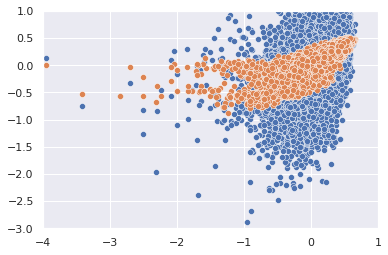

In [164]:
testru = np.hstack(gptrue)
testpred = np.hstack(gpres)
rfpred = (rf_fitted.predict(test_X) - test_y.mean()) / test_y.std()

print(kendalltau(testru, testpred)[0])
print(kendalltau(testru, rfpred)[0])

sns.scatterplot(testru, testpred)
sns.scatterplot(testru, rfpred)
plt.ylim(-3, 1)
plt.xlim(-4, 1)
plt.show()

In [51]:
data.sort_values('val_accs')

,net,val_accs,epe_nas,fisher,flops,grad_norm,grasp,jacov,l2_norm,nwot,params,plain,snip,synflow,zen,random,rank
263,"(0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",9.505209,472.269644,2.323591,155.898880,33.220974,-0.942154,-32.154222,394.344238,412.003164,0.882570,0.030701,179.167465,43.625583,48.210178,9103,9752.0
1571,"(0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",9.505209,462.244460,15.562840,590.812160,114.058556,-95.104736,-32.200648,802.517029,453.554859,3.667594,0.287300,847.899353,64.228582,88.877197,9739,9752.0
2166,"(0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ...",9.505209,399.345876,5.295909,223.024576,55.699764,-11.191528,-32.204057,444.113251,413.987097,1.443117,0.131559,270.968323,85.416656,60.883686,5203,9752.0
7623,"(0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, ...",9.505209,385.616686,77.906059,1819.939840,192.330063,-212.524170,-32.189980,834.088257,454.521782,12.252810,0.211516,1638.302490,100.267583,79.972954,3990,9752.0
9712,"(0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ...",9.505209,625.810703,595.982239,1673.073664,480.391632,-1930.246094,-32.206011,622.776367,445.925872,11.215242,0.295929,3795.601562,103.520107,69.670135,8469,9752.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,"(0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, ...",94.541264,428.797210,0.658794,1272.747008,24.907873,-0.253170,-32.188188,1190.498779,449.687076,8.555530,0.015413,166.380051,126.111483,122.025192,2506,5.0
920,"(0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",94.581330,407.344898,0.195279,1776.063488,17.930988,0.654632,-32.232444,1582.153931,461.033542,11.930506,-0.011905,127.323128,126.346381,168.153687,4420,4.0
7183,"(0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, ...",94.661456,531.397601,0.400077,1000.117248,18.670078,-0.089632,-32.215109,1236.263306,449.933900,6.667274,0.007747,123.924583,117.891556,118.293198,5922,3.0
4317,"(0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...",94.681489,446.817173,0.904824,1639.781376,35.810673,-5.223503,-32.240699,1190.226685,454.327905,11.056778,0.100577,231.551880,158.662300,135.504974,5079,2.0


In [52]:
import networkx as nx
#nx.adjacency_matrix(nets[7623][2]).todense()
aaa = data[data['val_accs'] < 50]
aaa

,net,val_accs,epe_nas,fisher,flops,grad_norm,grasp,jacov,l2_norm,nwot,params,plain,snip,synflow,zen,random,rank
49,"(0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",9.505209,433.688323,123.919083,377.329216,254.563446,-124.038086,-32.203517,565.585449,422.414740,2.495553,0.177834,1208.063965,110.028527,70.810349,4959,9752.0
51,"(0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",9.505209,357.311397,69.934242,595.203072,237.304932,-219.155273,-32.191107,818.633118,454.470932,3.831434,0.254608,1683.974121,89.979595,76.336594,6913,9752.0
263,"(0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",9.505209,472.269644,2.323591,155.898880,33.220974,-0.942154,-32.154222,394.344238,412.003164,0.882570,0.030701,179.167465,43.625583,48.210178,9103,9752.0
365,"(0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, ...",9.505209,362.659413,4.692320,238.642624,55.762527,-2.071350,-32.203489,566.135864,421.900824,1.560375,0.055324,263.810608,86.332746,69.281906,2327,9752.0
370,"(0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",9.505209,411.142992,22.892859,601.396224,128.527573,-148.324219,-32.199336,819.085083,454.372211,3.831434,0.219479,948.765259,84.665732,78.017593,1641,9752.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9321,"(0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, ...",9.505209,429.210968,7.740218,1526.207488,70.967033,-163.823792,-32.184144,410.810120,431.493054,10.177674,0.587396,506.002228,67.644402,56.201935,2046,9752.0
9505,"(0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",37.099358,537.117931,201.505447,1041.994752,430.745209,-2.375000,-32.212694,1454.467773,472.626220,6.944138,-0.000754,2895.174805,163.055979,110.891731,3003,9719.0
9666,"(0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, ...",9.505209,351.639844,15.135268,461.116416,77.718506,-34.846497,-32.218638,498.933228,425.004704,3.031562,0.152463,467.607178,86.147137,58.731270,7017,9752.0
9712,"(0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ...",9.505209,625.810703,595.982239,1673.073664,480.391632,-1930.246094,-32.206011,622.776367,445.925872,11.215242,0.295929,3795.601562,103.520107,69.670135,8469,9752.0


In [278]:
import networkx as nx

idx = 13

nx.adjacency_matrix(nets[aaa.index[idx]][2]).todense()
#nets[aaa.index[idx]][1]

matrix([[0, 1, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 1, 0, 1],
        [0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0]])

In [284]:
fd.loc[aaa.index][[c for c in fd.columns if 'max' in c]]

,max_op_on_path_allowed_[3],max_op_on_path_allowed_[4],"max_op_on_path_allowed_[3, 4]",max_op_on_path_allowed_[2],"max_op_on_path_allowed_[2, 3]","max_op_on_path_allowed_[2, 4]","max_op_on_path_allowed_[2, 3, 4]",node_degree_allowed_[]_max_out,node_degree_allowed_[]_max_in,node_degree_allowed_[2]_max_out,...,node_degree_allowed_[4]_max_out,node_degree_allowed_[4]_max_in,"node_degree_allowed_[3, 4]_max_out","node_degree_allowed_[3, 4]_max_in","node_degree_allowed_[2, 3, 4]_max_out","node_degree_allowed_[2, 3, 4]_max_in","node_degree_allowed_[2, 4]_max_out","node_degree_allowed_[2, 4]_max_in","node_degree_allowed_[2, 3]_max_out","node_degree_allowed_[2, 3]_max_in"
49,1,2,3,2,3,3,4,0,0,2,...,1,2,1,2,3,3,3,3,2,1
51,2,0,2,2,4,2,4,0,0,2,...,0,0,1,1,2,2,2,1,2,2
263,0,0,0,4,4,4,4,0,0,3,...,0,0,0,0,3,2,3,2,3,2
365,2,1,2,2,3,3,4,0,0,2,...,1,1,1,2,3,3,2,2,3,2
370,0,0,0,3,5,3,5,0,0,2,...,0,0,1,2,3,2,2,1,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9321,0,1,1,4,4,4,4,0,0,2,...,1,1,1,1,3,3,3,3,2,2
9505,5,0,5,0,5,0,5,0,0,0,...,0,0,2,2,2,2,0,0,2,2
9666,0,1,1,3,3,4,4,0,0,2,...,1,1,1,2,2,3,2,2,2,2
9712,1,1,2,2,3,3,4,0,0,3,...,1,1,1,2,3,3,3,3,3,2


In [280]:
np.array([nets[aaa.index[i]][1] for i in range(len(aaa))])

/tmp/ipykernel_11097/1119961400.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([nets[aaa.index[i]][1] for i in range(len(aaa))])


array([list([0, 3, 4, 4, 2, 2, 1]), list([0, 3, 3, 2, 2, 1]),
       list([0, 2, 2, 2, 2, 2, 1]), list([0, 3, 3, 2, 2, 4, 1]),
       list([0, 2, 3, 3, 2, 2, 1]), list([0, 3, 2, 2, 2, 2, 1]),
       list([0, 3, 3, 3, 3, 3, 1]), list([0, 3, 3, 3, 3, 3, 1]),
       list([0, 3, 2, 2, 2, 2, 1]), list([0, 4, 4, 2, 2, 2, 1]),
       list([0, 2, 2, 2, 2, 2, 1]), list([0, 3, 2, 2, 4, 2, 1]),
       list([0, 4, 2, 2, 4, 2, 1]), list([0, 4, 2, 2, 3, 2, 1]),
       list([0, 4, 2, 4, 2, 2, 1]), list([0, 4, 4, 4, 2, 2, 1]),
       list([0, 3, 3, 3, 3, 3, 1]), list([0, 3, 4, 2, 2, 2, 1]),
       list([0, 3, 3, 3, 3, 3, 1]), list([0, 2, 2, 2, 2, 1]),
       list([0, 3, 2, 3, 2, 2, 1]), list([0, 2, 2, 3, 2, 2, 1]),
       list([0, 2, 4, 2, 2, 2, 1]), list([0, 4, 2, 2, 2, 3, 1]),
       list([0, 3, 3, 3, 3, 3, 1]), list([0, 4, 2, 4, 2, 2, 1]),
       list([0, 4, 4, 2, 2, 3, 1]), list([0, 2, 4, 2, 4, 2, 1]),
       list([0, 4, 2, 2, 2, 4, 1]), list([0, 4, 2, 2, 2, 2, 1]),
       list([0, 4, 2, 2, 3, 2, 

In [285]:
nets[aaa.index[0]][2].edges

OutEdgeView([(0, 1), (1, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 6), (4, 5), (5, 6)])

In [248]:
from sklearn.decomposition import PCA

pca_data = fd#data[proxy_cols]
pca = PCA(n_components=2)
pca_data = pca.fit_transform(pca_data)
pca_data

array([[  92.38950574,  -72.37572629],
       [-285.80464836,  236.29062811],
       [-609.69343355,   25.83435388],
       ...,
       [-612.98712957,  -13.57477548],
       [-890.54169124,    7.24456938],
       [  -7.34587946,  -57.86322149]])

In [249]:
pca_tr = pca.transform(train_X)
pca_te = pca.transform(test_X)

In [250]:
rfpca = RandomForestRegressor()
rfpca.fit(pca_tr, train_y)
pred_pca = rfpca.predict(pca_te)
rfpca.score(pca_te, test_y)

0.05183267509882172

In [251]:
kendalltau(test_y, pred_pca)[0], spearmanr(test_y, pred_pca)[0]

(0.39076843162631614, 0.5495645906979418)

In [252]:
adj_acc = (data['val_accs'] - data['val_accs'].mean())
adj_acc[adj_acc < -10] = -12
adj_acc = adj_acc // 2
adj_acc.unique()

array([ 1., -1.,  0., -2., -6., -3., -4., -5.,  2.])

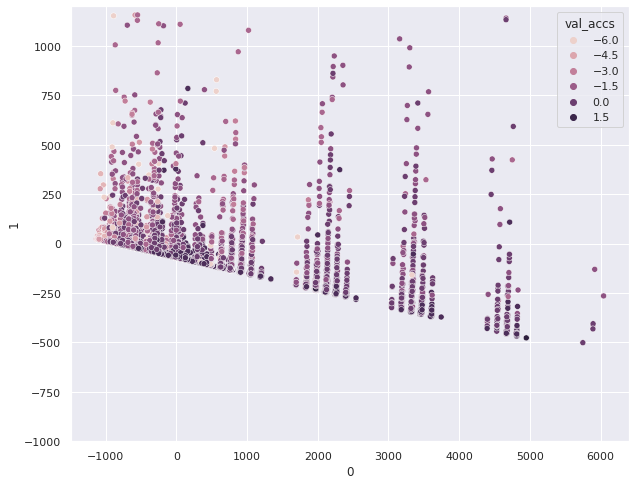

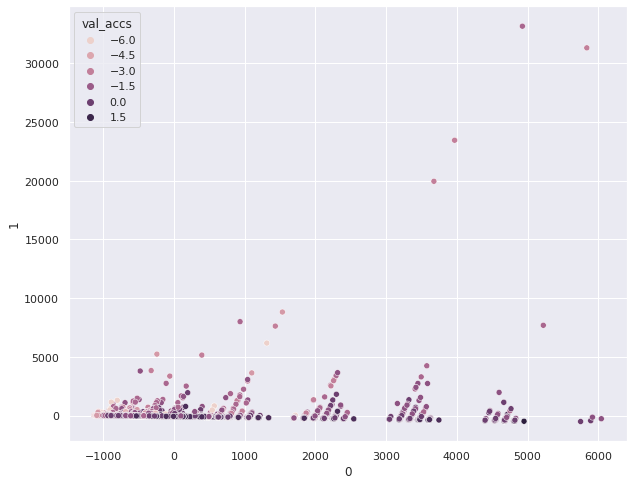

In [253]:
plot_dd = pd.DataFrame(pca_data)
plot_dd['val_accs'] = adj_acc

plt.figure(figsize=(10,8))
sns.scatterplot(data=plot_dd, x=0, y=1, hue='val_accs')
plt.ylim(-1000, 1200)
plt.show()

plt.figure(figsize=(10,8))
sns.scatterplot(data=plot_dd, x=0, y=1, hue='val_accs')
#plt.xlim(-2000, 5000)
plt.show()

In [254]:
imps = rf_fitted.feature_importances_

pd.DataFrame({"importance": imps, "feat": fd.columns}).sort_values('importance', ascending=False)

,importance,feat
68,0.201161,params
69,0.194248,flops
5,0.055197,min_path_len_banned_[]
6,0.052259,min_path_len_banned_[2]
70,0.050202,fisher
...,...,...
22,0.000000,node_degree_allowed_[]_avg_in
23,0.000000,node_degree_allowed_[]_avg_out
24,0.000000,node_degree_allowed_[]_max_out
25,0.000000,node_degree_allowed_[]_max_in


In [124]:
# IDEA ... sample different nets based on clustering (max distance between nets...)